In [1]:
##  TO-DO

# 1. Plot matching efficiencies by jet/tag category
# 2. Make BDT variable output automatic by key --> eliminate chance of user error

In [2]:
import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector
import matplotlib.pyplot as plt
import numpy as np
import itertools
import csv
import copy

t = 0.5  # transparency of plots

testRun = False
dR_cut_quarkToJet = 0.40
mass_higgs = 125.0 #GeV
width_higgs = 15.0 #GeV, reco width
minJetPt = 20.0 #GeV
maxJetAbsEta = 2.5

In [3]:
#delphes_hh= uproot.open('../../../MG5_aMC_v2_6_1/pp2hh4b_CMSPhaseII_200PU/Events/run_01_decayed_1/tag_2_delphes_events.root')['Delphes']
delphes_hh= uproot.open('../../../MG5_aMC_v2_6_1/pp2hh4b_CMSPhaseII_0PU/Events/run_04_decayed_1/tag_1_delphes_events.root')['Delphes']

#b_particles = uproot.tree.TBranchMethods.array(delphes_hh['Particle'])
l_genPID         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PID']).tolist()
l_genStatus      = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Status']).tolist()
l_genPt          = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PT']).tolist()
l_genEta         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Eta']).tolist()
l_genPhi         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Phi']).tolist()
l_genMass        = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Mass']).tolist()
l_jetPt          = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.PT']).tolist()
l_jetEta         = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Eta']).tolist()
l_jetPhi         = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Phi']).tolist()
l_jetMass        = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Mass']).tolist()
l_jetBTag        = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.BTag']).tolist()
l_missingET_met  = uproot.tree.TBranchMethods.array(delphes_hh['MissingET']['MissingET.MET']).tolist()
l_missingET_phi  = uproot.tree.TBranchMethods.array(delphes_hh['MissingET']['MissingET.Phi']).tolist()
l_scalarHT       = uproot.tree.TBranchMethods.array(delphes_hh['ScalarHT']['ScalarHT.HT']).tolist()


In [18]:
type(delphes_hh)
a = uproot.rootio.TObject

In [4]:
##############################################################
##                FUNCTIONS FOR PLOTTING                    ##
##############################################################

def plotOneHistogram(_arr, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins):
    #mean_arr = np.mean(arr)
    #stdev_arr = np.std(arr)
    #nEntries_arr = len(arr)

    #s1 = "Higgs Mass Reconstructed from 4 b-tagged jets:\n" \
    #     "entries = {}, mean = {:.4F}, std dev = {:.4F}".format(nEntries_arr, mean_arr, stdev_arr)

    plt.figure(_nPlot)
    plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
    plt.hist(_arr, _bins, alpha=t)
    #plt.legend(loc='upper right')
    #plt.text(10, 10, s1)
    plt.show()


    
def compareManyHistograms(_dict, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False):
    #_mean_arrAll     = np.mean(_arrAll)
    #_stdev_arrAll    = np.std(_arrAll)
    #_nEntries_arrAll = len(_arrAll)
    #s1 = _xtitle + ':Entries = {0}, mean = {1:4F}, std dev = {2:4f}\n'.format(_nEntries_arrAll, _mean_arrAll, _stdev_arrAll)
       
    if len(_dict.keys()) < len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
   
    for iLabel in _labels:
        plt.hist(_dict[iLabel], _bins, alpha=t, normed=_normed, label= iLabel+' Events')
    plt.legend(loc='upper right')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
    # save an image files
    _scope    = _title.split(' ')[0].lower()
    _variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','')
    _allLabels = ''.join(_labels)
    _filename  = _scope + '_' + pairingAlgorithm + '_' + _allLabels + '_' + _variable
    if _normed:
        _filename = _filename + '_norm'
    fig.savefig( _filename+'.png' )

In [5]:
##############################################################
##                FUNCTIONS FOR INDEXING                    ##
##############################################################

def returnListOfTruthBQuarkIndicesByDaughters(_D1, _D2, _PID):
    _bQuarkIndices = []
    
    for iParticle in range(0, len(_D1)):
         if _PID[iParticle]==25:
            _daughter1 = _D1[iParticle]
            _daughter2 = _D2[iParticle]
            _daughter1_PID = _PID[daughter1]
            _daughter2_PID = _PID[daughter2]
            #print('Event ',iEvt,'has higgs at position',iParticle,'with daughter1 (',daughter1,
            #    ') of PID',daughter1_PID,'and daughter2 (',daughter2,') of PID',daughter2_PID)
            if abs(_daughter1_PID) == 5 and abs(_daughter2_PID)==5:
                _bQuarkIndices.append(_daughter1)
                _bQuarkIndices.append(_daughter2)
    
    return _bQuarkIndices


def returnListOfTruthBQuarkIndicesByStatus(_status):
    _bQuarkIndices = []

    for iParticle in range(0, len(_status)):
        if _status[iParticle]==23:
            _bQuarkIndices.append(iParticle)

    return _bQuarkIndices

def returnNumberAndListOfJetIndicesPassingCuts(_jetPt, _jetEta, _jetMass, _jetBTag, _cut_jetPt, _cut_jetEta, _requireTags=False, _ptOrdered=False):
    _jetIndices = []
    _nJets = 0
    _nBTags = 0

    for iJet in range(0, len(_jetPt)): 
        if _jetPt[iJet] > _cut_jetPt and abs(_jetEta[iJet]) < _cut_jetEta and _jetMass[iJet]>0: 
            # surpringly some jets (<1%) have negative mass. filter these out
            _nJets += 1
            if not _requireTags:
                _jetIndices.append(iJet)
                
            if _jetBTag[iJet] == 1:
                _nBTags += 1
                if _requireTags: #and len(_jetIndices)<4:
                    if _ptOrdered:
                        _added = False
                        for index in range(0, len(_jetIndices)):
                            if _jetPt[iJet] > _jetPt[index] and _added==False:
                                _jetIndices.insert(index, iJet)
                                _added = True
                            
                        if _added == False:
                            _jetIndices.append(iJet)
                    else:
                        _jetIndices.append(iJet)
        
        #if len(_jetIndices)==4:
        #    break
            
    #print (_jetIndices)
    #print (_nJets, _nBTags, len(_jetIndices), [_jetPt[g] for g in _jetIndices])
    
    return _nJets, _nBTags, _jetIndices

def getDictOfQuarksMatchedToJets(_quarkIndices, _jetIndices, _genPt, _genEta, _genPhi, _genMass, _jetPt, _jetEta, _jetPhi, _jetMass): 
    _matchedQuarksToJets = {}
    _dictOfJetVectors = {}
    _dictOfQuarkVectors = {}
    
    for iQuark in _quarkIndices:
        tlv_quark = TLorentzVector.PtEtaPhiMassLorentzVector( _genPt[iQuark], _genEta[iQuark], _genPhi[iQuark], _genMass[iQuark])
        if iQuark not in _dictOfQuarkVectors.keys():
            _dictOfQuarkVectors[iQuark] = tlv_quark
            
        for iJet in _jetIndices:
            tlv_jet = TLorentzVector.PtEtaPhiMassLorentzVector( _jetPt[iJet], _jetEta[iJet], _jetPhi[iJet], _jetMass[iJet])
            if iJet not in _dictOfJetVectors.keys():
                _dictOfJetVectors[iJet] = tlv_jet
        
            # skip jets
            if tlv_quark.delta_r( tlv_jet) > dR_cut_quarkToJet:
                continue

            if iQuark not in _matchedQuarksToJets.keys():
                _matchedQuarksToJets.update({iQuark:[iJet]})
            else:
                _matchedQuarksToJets[iQuark].append(iJet)

    return _matchedQuarksToJets, _dictOfJetVectors, _dictOfQuarkVectors

In [6]:
##############################################################
##                FUNCTIONS FOR MATCHING                    ##
##############################################################

def getHarmonicMeanDeltaR(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _deltaR_pair1 = _jetVectorDict[_jetPairTuple[0]].delta_r(_jetVectorDict[_jetPairTuple[1]])
    _deltaR_pair2 = _jetVectorDict[_jetPairTuple[2]].delta_r(_jetVectorDict[_jetPairTuple[3]])
    if _deltaR_pair1 == 0 or _deltaR_pair2==0:
        print('pair1',_deltaR_pair1, _jetPairTuple[0], _jetPairTuple[1], _jetVectorDict[_jetPairTuple[0]].pt, _jetVectorDict[_jetPairTuple[1]].pt)
        print('pair2',_deltaR_pair2, _jetPairTuple[2], _jetPairTuple[3], _jetVectorDict[_jetPairTuple[2]].pt, _jetVectorDict[_jetPairTuple[3]].pt)
    
    # calculate the harmonic mean
    _meanDeltaR = np.reciprocal( ( np.reciprocal(_deltaR_pair1) + np.reciprocal(_deltaR_pair2) ) / 2 )
    #print(_jetPairTuple, _meanDeltaR, _deltaR_pair1, _deltaR_pair2)
    
    return _meanDeltaR
    
def getEqualDeltaR(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _deltaR_pair1 = _jetVectorDict[_jetPairTuple[0]].delta_r(_jetVectorDict[_jetPairTuple[1]])
    _deltaR_pair2 = _jetVectorDict[_jetPairTuple[2]].delta_r(_jetVectorDict[_jetPairTuple[3]])
    
    # calculate the harmonic mean
    _diffDeltaR = abs( _deltaR_pair1 - _deltaR_pair2 )
    #print(_jetPairTuple, _meanDeltaR, _deltaR_pair1, _deltaR_pair2)
    
    return _diffDeltaR

def getHiggsMassDifference(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # calculate the quadrature sum of higgs mass diff and divide by reco higgs width
    _quadratureMassDifference = np.sqrt( ( (_mass_pair1 - mass_higgs) / width_higgs )**2 + ( (_mass_pair2 - mass_higgs) / width_higgs )**2 )
    #print(_jetPairTuple, _quadratureMassDifference, _massDiff_pair1, _massDiff_pair2)
    
    return _quadratureMassDifference


def getDijetMassDifference(_jetPairTuple, _jetVectorDict):

    # get masses for each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # calculate the direct difference of reco dijet masses
    _dijetMassDifference = abs(_mass_pair1 - _mass_pair2)
    #print(_jetPairTuple, _quadratureMassDifference, _massDiff_pair1, _massDiff_pair2)
    
    return _dijetMassDifference


def getBothDijetMasses(_jetPairTuple, _jetVectorDict):

    # get masses of each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # make a list of the two masses
    _bothDijetMasses = [_mass_pair1, _mass_pair2 ]
    
    return _bothDijetMasses


def returnMetric(_pairingAlgorithm, _sortedTuple, _jetVectorDict):
    # calculate metric depending on chosen algorithm
    _metric = []
    
    if _pairingAlgorithm == "minHarmonicMeanDeltaR":
        _metric = getHarmonicMeanDeltaR(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "closestDijetMassesToHiggs":
        _metric = getHiggsMassDifference(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "equalDijetMass":
        _metric = getDijetMassDifference(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "equalDeltaR":
        _metric = getEqualDeltaR(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "dijetMasses":
        _metric = getBothDijetMasses(_sortedTuple, _jetVectorDict)
    
    _metric = _metric if type(_metric)==list else [_metric]
    return _metric
                
    
def selectPairsViaMatchingAlgorithm(_plottingData, _jetVectorDict, _pairingAlgorithm):

    # make list of pairs from [n choose 2] where n is number of jets
    _jetPairs = list(itertools.combinations(_jetVectorDict.keys(),2))
    _doubleJetPairs = {}
    
    # loop over jet pairs
    for pair in _jetPairs:
        # make list of leftover pairs that do not contain either jet in starting pair
        _notPair = [x for x in list(_jetPairs) if pair[0] not in x and pair[1] not in x]
        for pairOption in _notPair:
            _sortedPairing = sorted([sorted(x) for x in [pair, pairOption]])
            _sortedTuple = tuple(_sortedPairing[0]+_sortedPairing[1])

            # add double pairing to dictionary if not already present. sorting removes positional ambiguity
            if _sortedTuple not in _doubleJetPairs.keys():
                _metric = returnMetric(_pairingAlgorithm, _sortedTuple, _jetVectorDict)
              
                _doubleJetPairs[_sortedTuple] = _metric
                _plottingData[_pairingAlgorithm]['All'].extend( _metric )
                if thisEventIsMatchable:
                    _plottingData[_pairingAlgorithm]['Matchable'].extend( _metric )
                    
    # sort output dict and find minimal value
    _bestPairing = sorted(_doubleJetPairs.items(), key=lambda _pairingAndMetric: _pairingAndMetric[1][0])[0]
    _plottingData[_pairingAlgorithm]['Best'].extend( _bestPairing[1] )   
    if thisEventIsMatchable:
        # fill algorithm-selected lists for plotting
        _plottingData[_pairingAlgorithm]['Best+Matchable'].extend( _bestPairing[1] )
        
            
    return (_bestPairing[0][0], _bestPairing[0][1]), (_bestPairing[0][2] , _bestPairing[0][3]), _bestPairing[1][0]


def fillVariablePlotsForCorrectPairing(iEvt, _plottingData, _matchedJetVector, _pairingAlgorithm):
    _correctTuple = (0, 1, 2, 3)
    _metric = returnMetric(_pairingAlgorithm, _correctTuple, _matchedJetVector)
    _plottingData[_pairingAlgorithm]['Correct'].extend( _metric )
    if _metric[0]==0:
        print (iEvt)
        
    return
    


In [7]:
##############################################################
##                FUNCTIONS FOR EFFICIENCY                  ##
##############################################################

def returnJetTagLabels(_nJets, _nBTags):

    # every event is inclusive
    _categoryLabels = ['Incl']    
    
    # split into tag-inclusive bins, 6j means >= 6 jets
    if _nJets == 4:
        _categoryLabels.append('4jIncl')
    elif _nJets == 5:
        _categoryLabels.append('5jIncl')
    elif _nJets == 6:
        _categoryLabels.append('6jIncl')
    elif _nJets >= 7:
        _categoryLabels.append('7jIncl')
        
    # split into tag bins, 4b means >= 4 tags
    _jetLabel = str(_nJets) if _nJets <= 7 else str(7)
    _tagLabel = str(_nBTags) if _nBTags <= 7 else str(7)
    _categoryLabels.append( _jetLabel+'j'+_tagLabel+'b' )
    
    return _categoryLabels


def countEvents(_evtCounterDict, _cutflowBin, _nJets, _nBTags):

    _categoryLabels = returnJetTagLabels(_nJets, _nBTags)
    for iAlgorithm in _evtCounterDict:
        for iLabel in _categoryLabels:
            _evtCounterDict[iAlgorithm][iLabel][_cutflowBin] += 1
        
    
def evaluatePairingEfficiency(_evtCounterDict, _quarkToJetDict, _jetPair1, _jetPair2, _nJets, _nBTags, _algorithm):
                
        # Organize quark-to-jet pairs from truth into directly comparable tuples
        _indexList = list( _quarkToJetDict.values() ) 
        _orderedIndexTuple = sorted( ( tuple(sorted( (_indexList[0][0], _indexList[1][0]) )) , tuple(sorted( (_indexList[2][0], _indexList[3][0]) )) ) )
        _indexPair1 = _orderedIndexTuple[0]
        _indexPair2 = _orderedIndexTuple[1]
        
        # Do some global counting
        _categoryLabels = returnJetTagLabels(_nJets, _nBTags)
        for iLabel in _categoryLabels:
            if _jetPair1 == _indexPair1 and _jetPair2 == _indexPair2:
                _evtCounterDict[_algorithm][iLabel]['Fully Matched'] += 1
         
            if _jetPair1 == _indexPair1 or _jetPair2 == _indexPair2:
                _evtCounterDict[_algorithm][iLabel]['>= 1 Pair Matched'] += 1
        
        return 
    
def printEventCounterInfo( _evtCounterDict, _catTag ):

    print('====================================================')
    print("!!!! Event Counter Info For "+_catTag)
    print("Number of Events:", _evtCounterDict[_catTag]['All'])
    print("Number of Events with 4 truth-matchable jets:", _evtCounterDict[_catTag]['Matchable'])
    print("Number of Events Fully Matched:", _evtCounterDict[_catTag]['Fully Matched'])
    print("Number of Events with >= 1 Pair Matched:", _evtCounterDict[_catTag]['>= 1 Pair Matched'])
    if _evtCounterDict[_catTag]['Matchable'] > 0:
        print('Efficiency For Fully Matched: ',round( 100*float(_evtCounterDict[_catTag]['Fully Matched']/_evtCounterDict[_catTag]['Matchable']) , 2),'%')
        print('Efficiency For >= 1 Pair Matched: ',round( 100*float(_evtCounterDict[_catTag]['>= 1 Pair Matched']/_evtCounterDict[_catTag]['Matchable']) , 2),'%')
 
    return


def listOfEfficiencesForAlgorithm(_evtCounterDict):
    _fullyMatchedDict = {}
    _onePairMatchedDict = {}
    
    for _iAlgorithm in _evtCounterDict:
        _fullyMatchedDict[_iAlgorithm] = {}
        _onePairMatchedDict[_iAlgorithm] = {}
        for _iCategory in _evtCounterDict[_iAlgorithm]:
            if _evtCounterDict[_iAlgorithm][_iCategory]['Matchable'] > 0:
                _fullyMatchedEff  = round( 100*float(_evtCounterDict[_iAlgorithm][_iCategory]['Fully Matched']/_evtCounterDict[_iAlgorithm][_iCategory]['Matchable']), 2)
                _onePairMatchedEff = round( 100*float(_evtCounterDict[_iAlgorithm][_iCategory]['>= 1 Pair Matched']/_evtCounterDict[_iAlgorithm][_iCategory]['Matchable']), 2)
                _fullyMatchedDict[_iAlgorithm][_iCategory] = _fullyMatchedEff
                _onePairMatchedDict[_iAlgorithm][_iCategory] = _onePairMatchedEff
                #print(_algorithm, _iCategory)
                #print('Efficiency For Fully Matched: ', _fullyMatchedEff,'%')
                #print('Efficiency For >= 1 Pair Matched: ', _onePairMatchedEff,'%')
 
    return _fullyMatchedDict, _onePairMatchedDict

    

In [8]:
##############################################################
##           FUNCTIONS FOR CALCULATING BDT VARS             ##
##############################################################

def createOutputVariableList(_nJetsToStore):
    _variableNameList = ['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met', 'met_phi', 'scalarHT', 'nJets', 'nBTags']
    _jetVariables = ['pt', 'eta', 'phi', 'mass', 'px', 'py', 'pz', 'energy']
    
    for _variable in _jetVariables:
        _variableNameList.extend( ['jet'+str(_iJet)+'_'+str(_variable) for _iJet in range(1,_nJetsToStore+1)])
    
        
    return _variableNameList


def calculateVariablesForBDT( _jetPair1, _jetPair2, _jetVectorDict, _nJets, _nBTags, _met, _met_phi, _scalarHT, _addLowLevel = False):
    _variableList = []
    
    _tlv_h1_j0 = _jetVectorDict[ _jetPair1[0] ]
    _tlv_h1_j1 = _jetVectorDict[ _jetPair1[1] ]
    _tlv_h2_j2 = _jetVectorDict[ _jetPair2[0] ]
    _tlv_h2_j3 = _jetVectorDict[ _jetPair2[1] ]
    _tlv_h1 = _tlv_h1_j0 + _tlv_h1_j1
    _tlv_h2 = _tlv_h2_j2 + _tlv_h2_j3

    """print('====================================================')
    print ("hh mass: ", (_tlv_h1 + _tlv_h2).mass)
    print ("h1 mass: ", _tlv_h1.energy, _tlv_h1.p, _tlv_h1_j0.energy, _tlv_h1_j0.p, _tlv_h1_j1.energy, _tlv_h1_j1.p)
    print ("h2 mass: ", _tlv_h2.mass)
    print ("hh pt: ", (_tlv_h1 + _tlv_h2).pt)
    print ("h1 pt: ", _tlv_h1.pt)
    print ("h2 pt: ", _tlv_h2.pt)
    print ("dR(h1, h2): ",  _tlv_h1.delta_r( _tlv_h2 ))
    print ("for h1, dR(j0, j1): ",  _tlv_h1_j0.delta_r( _tlv_h1_j1 ))
    print ("for h2, dR(j2, j3): ",  _tlv_h2_j2.delta_r( _tlv_h2_j3 ))
    print ("for h1, dPhi(j0, j1): ",  _tlv_h1_j0.delta_phi( _tlv_h1_j1 ))
    print ("for h2, dPhi(j2, j3): ",  _tlv_h2_j2.delta_phi( _tlv_h2_j3 ))
    #print ("MET, met_phi: ", _met[0], _met_phi[0])
    #print ("Scalar HT: ", _scalarHT[0])
    #print ("nJets, nBTags: ", _nJets, _nBTags)
    """
    _nDigits = 3
    
    _variableList = [ (_tlv_h1 + _tlv_h2).mass, _tlv_h1.mass, _tlv_h2.mass,
                     (_tlv_h1 + _tlv_h2).pt, _tlv_h1.pt, _tlv_h2.pt,
                    _tlv_h1.delta_r(_tlv_h2), 
                    _tlv_h1_j0.delta_r(_tlv_h1_j1), _tlv_h2_j2.delta_r(_tlv_h2_j3), 
                    _tlv_h1_j0.delta_phi(_tlv_h1_j1), _tlv_h2_j2.delta_phi(_tlv_h2_j3), 
                    _met[0], _met_phi[0], _scalarHT[0], 
                    _nJets, _nBTags,
                    _tlv_h1_j0.pt, _tlv_h1_j1.pt, _tlv_h2_j2.pt, _tlv_h2_j3.pt, 
                    _tlv_h1_j0.eta, _tlv_h1_j1.eta, _tlv_h2_j2.eta, _tlv_h2_j3.eta,
                    _tlv_h1_j0.phi, _tlv_h1_j1.phi, _tlv_h2_j2.phi, _tlv_h2_j3.phi,
                    _tlv_h1_j0.mass, _tlv_h1_j1.mass, _tlv_h2_j2.mass, _tlv_h2_j3.mass,
                    _tlv_h1_j0.x, _tlv_h1_j1.x, _tlv_h2_j2.x, _tlv_h2_j3.x, 
                    _tlv_h1_j0.y, _tlv_h1_j1.y, _tlv_h2_j2.y, _tlv_h2_j3.y, 
                    _tlv_h1_j0.z, _tlv_h1_j1.z, _tlv_h2_j2.z, _tlv_h2_j3.z, 
                    _tlv_h1_j0.energy, _tlv_h1_j1.energy, _tlv_h2_j2.energy, _tlv_h2_j3.energy
                    ]
        
    return _variableList

In [9]:
outputDataForLearning = []
nJetsToStore = 4
outputVariableNames = createOutputVariableList(nJetsToStore)

##  Without quality cuts on pairing algorithms:
##  closestDijetMassesToHiggs   gets both pairs correct 46.7% of the time
##  minHarmonicMeanDeltaR       gets both pairs correct 34.8% of the time
##  equalDeltaR                 gets both pairs correct 18.9% of the time
##  equalDijetMass              gets both pairs correct 17.2% of the time
##  dijetMasses                 IS NOT A MINIMIZATION METRIC

saveAlgorithm = 'minHarmonicMeanDeltaR' # options include: 1) minHarmonicMeanDeltaR, 2) higgsMassDifference, 3) dijetMassDifference, 4) equal Delta R
pairingAlgorithms = ['minHarmonicMeanDeltaR', 'closestDijetMassesToHiggs', 'equalDijetMass', 'equalDeltaR', 'dijetMasses']
variableCategoryDict = {'All':[], 'Matchable':[], 'Best':[], 'Best+Matchable':[], 'Correct':[]}

cutflowDict = { 'All':0, 'Matchable':0, 'Fully Matched':0, '>= 1 Pair Matched':0}
jetTagCategories = ['Incl',
                    '4jIncl', '4j0b', '4j1b', '4j2b', '4j3b', '4j4b', 
                    '5jIncl', '5j0b', '5j1b', '5j2b', '5j3b', '5j4b', '5j5b', 
                    '6jIncl', '6j0b', '6j1b', '6j2b', '6j3b', '6j4b', '6j5b', '6j6b',
                    '7jIncl', '7j0b', '7j1b', '7j2b', '7j3b', '7j4b', '7j5b', '7j6b', '7j7b']


plottingData = {algorithm:copy.deepcopy(variableCategoryDict) for algorithm in pairingAlgorithms}
eventCounterDict = { algorithm:{category:copy.deepcopy(cutflowDict) for category in jetTagCategories} for algorithm in pairingAlgorithms}
nBTagsPerEvent  = []
nJetsPerEvent   = []
thisEventIsMatchable = False
thisEventWasCorrectlyMatched = False


for iEvt in range(0,delphes_hh.fEntries):
    # *** 0. Kick-out condition for testing
    if iEvt > 40 and testRun is True:
        continue
    if iEvt%2000==0:
        print("Analyzing event number",iEvt)
    
    # *** 1. Get truth information
    indicesByStatus    = returnListOfTruthBQuarkIndicesByStatus(l_genStatus[iEvt])   
    if len(indicesByStatus) != 4:
        print ("!!! WARNING: iEvt = {0} did not find 4 truth b-quarks. Only found {1} !!!".format(iEvt, len(indicesByStatus)))
        continue
        
    # *** 2. Get jet reco information
    nJets, nBTags, jetIndices = returnNumberAndListOfJetIndicesPassingCuts(l_jetPt[iEvt], l_jetEta[iEvt], l_jetMass[iEvt], l_jetBTag[iEvt], minJetPt, maxJetAbsEta, _requireTags=True, _ptOrdered=True)
    nJetsPerEvent.append(nJets)
    nBTagsPerEvent.append(nBTags)

    #if nJets < 4: continue 
    #if len(jetIndices) < 4: continue 
    if nBTags < 4: continue 
    countEvents( eventCounterDict, 'All', nJets, nBTags )
    
    # *** 3. Do some quark-to-jet truth matching
    thisEventIsMatchable = False
    thisEventWasCorrectlyMatched = False
    matchedQuarksToJets, jetVectorDict, quarkVectorDict = getDictOfQuarksMatchedToJets(indicesByStatus, jetIndices, l_genPt[iEvt], l_genEta[iEvt], l_genPhi[iEvt], l_genMass[iEvt], l_jetPt[iEvt], l_jetEta[iEvt], l_jetPhi[iEvt], l_jetMass[iEvt])
    # Check if a) all matches have one and only match between quark and jet, b) four jets are matched, c) 4 unique reconstructed jets are selected
    jetIndexList = [recoIndex[0] for recoIndex in matchedQuarksToJets.values()]
    if all(len(matchedJets) == 1 for matchedJets in matchedQuarksToJets.values()) and len(matchedQuarksToJets)==4  and (len(set(jetIndexList)) == len(jetIndexList)):     
        thisEventIsMatchable = True
        countEvents( eventCounterDict, 'Matchable', nJets, nBTags )
        
    # *** 4. Evaluate all pairing algorithms
    for iAlgorithm in pairingAlgorithms:
        # ** A. Fill algorithm metric for correct pairing (regardless if chosen by metric)
        if thisEventIsMatchable == True:
            fillVariablePlotsForCorrectPairing(iEvt, plottingData, [jetVectorDict[matchedJet[0]] for matchedJet in matchedQuarksToJets.values()], iAlgorithm)

        # ** B. Pick two jet pairs based on algorithm
        jetPair1, jetPair2, pairingMetric = selectPairsViaMatchingAlgorithm(plottingData, jetVectorDict, iAlgorithm)
    
        # ** C. Evaluate efficiency of pairing algorithm
        if thisEventIsMatchable:
            evaluatePairingEfficiency(eventCounterDict, matchedQuarksToJets, jetPair1, jetPair2, nJets, nBTags, iAlgorithm)
    
        # ** D. Calculate and save variables for BDT training for single algorithm set by saveAlgorithm
        if iAlgorithm == saveAlgorithm: 
            variablesForBDT = calculateVariablesForBDT(jetPair1, jetPair2, jetVectorDict, nJets, nBTags, 
                                                        l_missingET_met[iEvt], l_missingET_phi[iEvt], l_scalarHT[iEvt])
            outputDataForLearning.append(variablesForBDT)

    
# *** 5. Store output data in .csv for later usage
csvFile = open('dihiggsOutputDataForLearning.csv', mode='w')
writer = csv.DictWriter(csvFile, fieldnames=outputVariableNames)
writer.writeheader()
for eventData in outputDataForLearning:
    csvLineDict = {}
    # format csv line using names of variables
    for iVariable in range(0, len(outputVariableNames)):
        csvLineDict[ outputVariableNames[iVariable] ] = eventData[iVariable]
    # write line to .csv
    writer.writerow( csvLineDict )
csvFile.close()


# *** 8. Print event counter info 
printEventCounterInfo(eventCounterDict['closestDijetMassesToHiggs'], 'Incl')
printEventCounterInfo(eventCounterDict['closestDijetMassesToHiggs'], '4jIncl')
printEventCounterInfo(eventCounterDict['closestDijetMassesToHiggs'], '4j4b')
#print (eventCounterDict)
#printEventCounterInfo(eventCounterDict_4b, '>= 4 b-Tags')

Analyzing event number 0
Analyzing event number 2000
Analyzing event number 4000
Analyzing event number 6000
Analyzing event number 8000
Analyzing event number 10000
Analyzing event number 12000
Analyzing event number 14000
Analyzing event number 16000
Analyzing event number 18000
Analyzing event number 20000
Analyzing event number 22000
Analyzing event number 24000
Analyzing event number 26000
Analyzing event number 28000
!!!! Event Counter Info For Incl
Number of Events: 4603
Number of Events with 4 truth-matchable jets: 2663
Number of Events Fully Matched: 1834
Number of Events with >= 1 Pair Matched: 1889
Efficiency For Fully Matched:  68.87 %
Efficiency For >= 1 Pair Matched:  70.94 %
!!!! Event Counter Info For 4jIncl
Number of Events: 1033
Number of Events with 4 truth-matchable jets: 755
Number of Events Fully Matched: 557
Number of Events with >= 1 Pair Matched: 557
Efficiency For Fully Matched:  73.77 %
Efficiency For >= 1 Pair Matched:  73.77 %
!!!! Event Counter Info For 4j

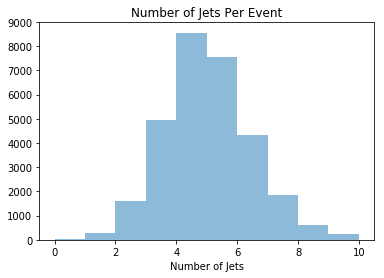

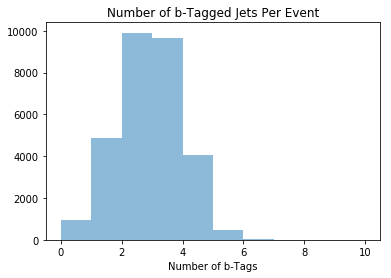

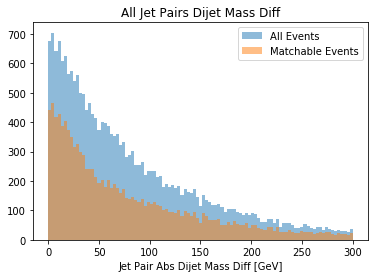

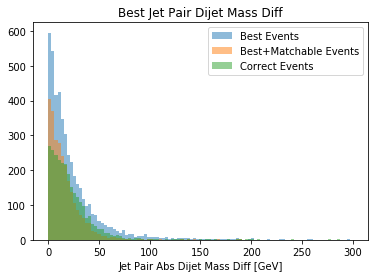

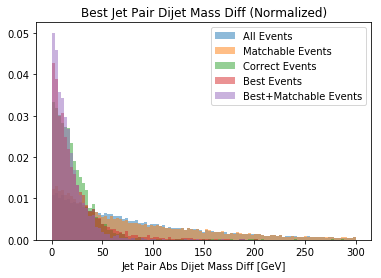

In [12]:
pairingAlgorithm = 'equalDijetMass'
plotOpts = [] # title, xtitle, xMin, xMax, nBins
if pairingAlgorithm == 'minHarmonicMeanDeltaR':
    plotOpts = ['Delta R', 'Delta R', 0, 5.0, 100]
elif pairingAlgorithm == 'closestDijetMassesToHiggs':
    plotOpts = ['Higgs Mass Diff', 'Higgs Mass Diff', 0, 50.0, 50]
elif pairingAlgorithm == 'equalDijetMass':
    plotOpts = ['Dijet Mass Diff', 'Abs Dijet Mass Diff [GeV]', -0.0, 300.0, 100]
elif pairingAlgorithm == 'equalDeltaR':
    plotOpts = ['Delta R', 'Delta R(h1, h2)', 0, 5.0, 100]
elif pairingAlgorithm == 'dijetMasses':
    plotOpts = ['Dijet Mass', 'Dijet Mass [GeV]', 0, 600.0, 100]
    
plotOneHistogram(nJetsPerEvent, 0, 'Number of Jets Per Event', 'Number of Jets', 0, 10, 11 )
plotOneHistogram(nBTagsPerEvent, 1, 'Number of b-Tagged Jets Per Event', 'Number of b-Tags', 0, 10, 11 )

compareManyHistograms( plottingData[pairingAlgorithm], ['All', 'Matchable'], 2, 'All Jet Pairs ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]), int(plotOpts[3]), int(plotOpts[4]) )
compareManyHistograms( plottingData[pairingAlgorithm], ['Best', 'Best+Matchable', 'Correct'], 3, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]), int(plotOpts[3]), int(plotOpts[4]) )
compareManyHistograms( plottingData[pairingAlgorithm], ['All', 'Matchable', 'Correct', 'Best', 'Best+Matchable'], 5, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]), int(plotOpts[3]), int(plotOpts[4]), _normed=True)

# Look at higgs masss plots
#compareManyHistograms( plottingData['dijetMasses'], ['All', 'Matchable', 'Best', 'Best+Matchable'], 6, 'All Jet Pairs Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )
#compareManyHistograms( plottingData['dijetMasses'], ['All', 'Matchable'], 6, 'All Jet Pairs Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )
#compareManyHistograms( plottingData['dijetMasses'], ['Best', 'Best+Matchable','Correct'], 7, 'Best Jet Pair Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )


In [19]:
for algo in pairingAlgorithms:
    print(algo)
    printEventCounterInfo(eventCounterDict[algo], '5j5b')


minHarmonicMeanDeltaR
!!!! Event Counter Info For 5j5b
Number of Events: 143
Number of Events with 4 truth-matchable jets: 51
Number of Events Fully Matched: 47
Number of Events with >= 1 Pair Matched: 47
Efficiency For Fully Matched:  92.16 %
Efficiency For >= 1 Pair Matched:  92.16 %
closestDijetMassesToHiggs
!!!! Event Counter Info For 5j5b
Number of Events: 143
Number of Events with 4 truth-matchable jets: 51
Number of Events Fully Matched: 46
Number of Events with >= 1 Pair Matched: 46
Efficiency For Fully Matched:  90.2 %
Efficiency For >= 1 Pair Matched:  90.2 %
equalDijetMass
!!!! Event Counter Info For 5j5b
Number of Events: 143
Number of Events with 4 truth-matchable jets: 51
Number of Events Fully Matched: 36
Number of Events with >= 1 Pair Matched: 36
Efficiency For Fully Matched:  70.59 %
Efficiency For >= 1 Pair Matched:  70.59 %
equalDeltaR
!!!! Event Counter Info For 5j5b
Number of Events: 143
Number of Events with 4 truth-matchable jets: 51
Number of Events Fully Match

In [59]:
import itertools
a=[1,2,3,4,5,6,7]
pairs = list(itertools.combinations(a,2))
#list(pairs)
pairPairs = {}
for two in pairs:
    notwo = [x for x in list(pairs) if two[0] not in x and two[1] not in x]
    for pairOption in notwo:
        sortedPairing = sorted([sorted(x) for x in [two, pairOption]])
        sortedTuple = tuple(sortedPairing[0]+sortedPairing[1])

        if sortedTuple not in pairPairs.keys():
            pairPairs[sortedTuple]=0

print(len(pairPairs))
print(pairPairs)
    

{'minHarmonicMeanDeltaR': {'Incl': 76.65, '4jIncl': 78.92, '4j4b': 78.92, '5jIncl': 77.02, '5j4b': 77.02, '6jIncl': 70.8, '6j4b': 70.8, '7jIncl': 71.43, '7j4b': 71.43}, 'closestDijetMassesToHiggs': {'Incl': 89.07, '4jIncl': 89.46, '4j4b': 89.46, '5jIncl': 88.09, '5j4b': 88.09, '6jIncl': 90.27, '6j4b': 90.27, '7jIncl': 88.1, '7j4b': 88.1}, 'equalDijetMass': {'Incl': 75.57, '4jIncl': 73.22, '4j4b': 73.22, '5jIncl': 75.74, '5j4b': 75.74, '6jIncl': 83.19, '6j4b': 83.19, '7jIncl': 73.81, '7j4b': 73.81}, 'equalDeltaR': {'Incl': 44.26, '4jIncl': 50.14, '4j4b': 50.14, '5jIncl': 41.7, '5j4b': 41.7, '6jIncl': 30.97, '6j4b': 30.97, '7jIncl': 45.24, '7j4b': 45.24}, 'dijetMasses': {'Incl': 83.0, '4jIncl': 86.04, '4j4b': 86.04, '5jIncl': 84.68, '5j4b': 84.68, '6jIncl': 76.99, '6j4b': 76.99, '7jIncl': 64.29, '7j4b': 64.29}}


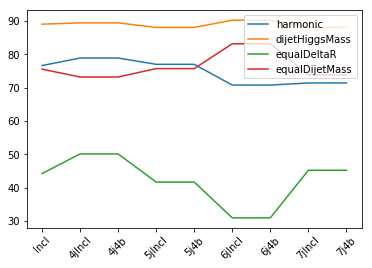

In [80]:
fullDict, oneDict = listOfEfficiencesForAlgorithm(eventCounterDict)
print (fullDict)
np.arange(19)
for algo in fullDict:
    labels_only4 = [tagEff for tagEff in fullDict[algo]]
    eff    = [fullDict[algo][tagEff] for tagEff in fullDict[algo]]
    #print (algo)
    #print (labels)
    #print (eff)

eff_harmonic_only4 = [fullDict['minHarmonicMeanDeltaR'][tagEff] for tagEff in fullDict['minHarmonicMeanDeltaR']]
eff_dijetHiggsMass_only4 = [fullDict['closestDijetMassesToHiggs'][tagEff] for tagEff in fullDict['closestDijetMassesToHiggs']]
eff_equalDeltaR_only4 = [fullDict['equalDeltaR'][tagEff] for tagEff in fullDict['equalDeltaR']]
eff_equalDijetMass_only4 = [fullDict['equalDijetMass'][tagEff] for tagEff in fullDict['equalDijetMass']]

xvals_only4 = np.arange(len(labels_only4))
y_harmonic_only4 = np.array(eff_harmonic_only4)
y_dijetHiggsMass_only4 = np.array(eff_dijetHiggsMass_only4)
y_equalDeltaR_only4 = np.array(eff_equalDeltaR_only4)
y_equalDijetMass_only4 = np.array(eff_equalDijetMass_only4)

plt.xticks(range(len(labels_only4)), labels_only4, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_only4, y_harmonic_only4, label='harmonic')
plt.plot(xvals_only4, y_dijetHiggsMass_only4, label='dijetHiggsMass')
plt.plot(xvals_only4, y_equalDeltaR_only4, label='equalDeltaR')
plt.plot(xvals_only4, y_equalDijetMass_only4, label='equalDijetMass')

plt.legend(loc='upper right')

# store figure copy for later saving
fig = plt.gcf()
    
# draw interactively
plt.show()
    
fig.savefig( 'algoEfficiencyAsFtnOfJetTag_onlyBtags.png' )


{'minHarmonicMeanDeltaR': {'Incl': 70.42, '4jIncl': 73.12, '4j4b': 73.12, '5jIncl': 71.75, '5j4b': 76.59, '5j5b': 20.99, '6jIncl': 69.78, '6j4b': 80.37, '6j5b': 10.59, '6j6b': 16.67, '7jIncl': 64.16, '7j4b': 80.17, '7j5b': 15.22, '7j6b': 9.52}, 'closestDijetMassesToHiggs': {'Incl': 68.1, '4jIncl': 73.25, '4j4b': 73.25, '5jIncl': 68.74, '5j4b': 72.71, '5j5b': 27.16, '6jIncl': 65.98, '6j4b': 74.02, '6j5b': 23.53, '6j6b': 8.33, '7jIncl': 61.16, '7j4b': 73.37, '7j5b': 22.83, '7j6b': 23.81}, 'equalDijetMass': {'Incl': 70.85, '4jIncl': 75.84, '4j4b': 75.84, '5jIncl': 71.32, '5j4b': 75.41, '5j5b': 28.4, '6jIncl': 69.3, '6j4b': 77.76, '6j5b': 25.88, '6j6b': 0.0, '7jIncl': 63.73, '7j4b': 76.49, '7j5b': 28.26, '7j6b': 4.76}, 'equalDeltaR': {'Incl': 42.23, '4jIncl': 52.47, '4j4b': 52.47, '5jIncl': 43.93, '5j4b': 46.24, '5j5b': 19.75, '6jIncl': 36.87, '6j4b': 42.24, '6j5b': 8.24, '6j6b': 0.0, '7jIncl': 29.18, '7j4b': 36.54, '7j5b': 5.43, '7j6b': 9.52}, 'dijetMasses': {'Incl': 74.96, '4jIncl': 83.3

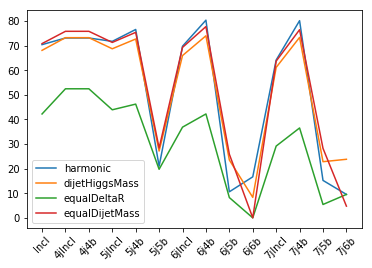

In [26]:
fullDict, oneDict = listOfEfficiencesForAlgorithm(eventCounterDict)
print (fullDict)
np.arange(19)
for algo in fullDict:
    labels_allB = [tagEff for tagEff in fullDict[algo]]
    eff    = [fullDict[algo][tagEff] for tagEff in fullDict[algo]]
    #print (algo)
    #print (labels)
    #print (eff)

eff_harmonic_allB = [fullDict['minHarmonicMeanDeltaR'][tagEff] for tagEff in fullDict['minHarmonicMeanDeltaR']]
eff_dijetHiggsMass_allB = [fullDict['closestDijetMassesToHiggs'][tagEff] for tagEff in fullDict['closestDijetMassesToHiggs']]
eff_equalDeltaR_allB = [fullDict['equalDeltaR'][tagEff] for tagEff in fullDict['equalDeltaR']]
eff_equalDijetMass_allB = [fullDict['equalDijetMass'][tagEff] for tagEff in fullDict['equalDijetMass']]

xvals_allB = np.arange(len(labels_allB))
y_harmonic_allB = np.array(eff_harmonic_allB)
y_dijetHiggsMass_allB = np.array(eff_dijetHiggsMass_allB)
y_equalDeltaR_allB = np.array(eff_equalDeltaR_allB)
y_equalDijetMass_allB = np.array(eff_equalDijetMass_allB)

plt.xticks(range(len(labels_allB)), labels_allB, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_allB, y_harmonic_allB, label='harmonic')
plt.plot(xvals_allB, y_dijetHiggsMass_allB, label='dijetHiggsMass')
plt.plot(xvals_allB, y_equalDeltaR_allB, label='equalDeltaR')
plt.plot(xvals_allB, y_equalDijetMass_allB, label='equalDijetMass')

plt.legend(loc='lower left')

# store figure copy for later saving
fig = plt.gcf()
    
# draw interactively
plt.show()
    
fig.savefig( 'algoEfficiencyAsFtnOfJetTag_allBtags.png' )

{'minHarmonicMeanDeltaR': {'Incl': 77.68, '4jIncl': 73.12, '4j4b': 73.12, '5jIncl': 77.47, '5j4b': 76.59, '5j5b': 92.16, '6jIncl': 81.05, '6j4b': 80.37, '6j5b': 87.04, '6j6b': 100.0, '7jIncl': 81.69, '7j4b': 80.17, '7j5b': 88.73, '7j6b': 100.0}, 'closestDijetMassesToHiggs': {'Incl': 73.18, '4jIncl': 73.25, '4j4b': 73.25, '5jIncl': 73.7, '5j4b': 72.71, '5j5b': 90.2, '6jIncl': 72.59, '6j4b': 74.02, '6j5b': 59.26, '6j6b': 50.0, '7jIncl': 72.77, '7j4b': 73.37, '7j5b': 70.42, '7j6b': 50.0}, 'equalDijetMass': {'Incl': 75.78, '4jIncl': 75.84, '4j4b': 75.84, '5jIncl': 75.14, '5j4b': 75.41, '5j5b': 70.59, '6jIncl': 77.66, '6j4b': 77.76, '6j5b': 77.78, '6j6b': 50.0, '7jIncl': 74.41, '7j4b': 76.49, '7j5b': 63.38, '7j6b': 100.0}, 'equalDeltaR': {'Incl': 45.39, '4jIncl': 52.47, '4j4b': 52.47, '5jIncl': 46.61, '5j4b': 46.24, '5j5b': 52.94, '6jIncl': 41.62, '6j4b': 42.24, '6j5b': 33.33, '6j6b': 100.0, '7jIncl': 35.21, '7j4b': 36.54, '7j5b': 26.76, '7j6b': 100.0}, 'dijetMasses': {'Incl': 83.11, '4jInc

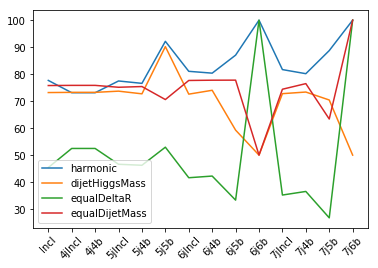

In [15]:
fullDict, oneDict = listOfEfficiencesForAlgorithm(eventCounterDict)
print (fullDict)
np.arange(19)
for algo in fullDict:
    labels_top4 = [tagEff for tagEff in fullDict[algo]]
    eff    = [fullDict[algo][tagEff] for tagEff in fullDict[algo]]
    #print (algo)
    #print (labels)
    #print (eff)

eff_harmonic_top4 = [fullDict['minHarmonicMeanDeltaR'][tagEff] for tagEff in fullDict['minHarmonicMeanDeltaR']]
eff_dijetHiggsMass_top4 = [fullDict['closestDijetMassesToHiggs'][tagEff] for tagEff in fullDict['closestDijetMassesToHiggs']]
eff_equalDeltaR_top4 = [fullDict['equalDeltaR'][tagEff] for tagEff in fullDict['equalDeltaR']]
eff_equalDijetMass_top4 = [fullDict['equalDijetMass'][tagEff] for tagEff in fullDict['equalDijetMass']]

xvals_top4 = np.arange(len(labels_top4))
y_harmonic_top4 = np.array(eff_harmonic_top4)
y_dijetHiggsMass_top4 = np.array(eff_dijetHiggsMass_top4)
y_equalDeltaR_top4 = np.array(eff_equalDeltaR_top4)
y_equalDijetMass_top4 = np.array(eff_equalDijetMass_top4)

plt.xticks(range(len(labels_top4)), labels_top4, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_top4, y_harmonic_top4, label='harmonic')
plt.plot(xvals_top4, y_dijetHiggsMass_top4, label='dijetHiggsMass')
plt.plot(xvals_top4, y_equalDeltaR_top4, label='equalDeltaR')
plt.plot(xvals_top4, y_equalDijetMass_top4, label='equalDijetMass')

plt.legend(loc='lower left')

# store figure copy for later saving
fig = plt.gcf()
    
# draw interactively
plt.show()
    
fig.savefig( 'algoEfficiencyAsFtnOfJetTag_top4Btags.png' )


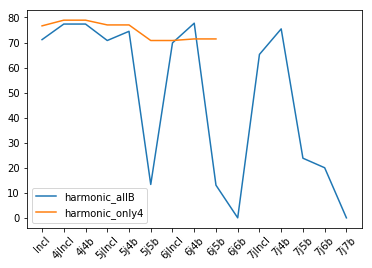

In [90]:
plt.xticks(range(len(labels_allB)), labels_allB, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_allB, y_harmonic_allB, label='harmonic_allB')
plt.plot(xvals_only4, y_harmonic_only4, label='harmonic_only4')

plt.legend(loc='lower left')

plt.show()

In [48]:
a=["j1","j2","j3","j4", ["j"+str(x) for x in range(5,7)]]
b=[["j1","j2","j3","j4"], ["j"+str(x) for x in range(5,7)]]

In [38]:
a

['j1', 'j2', 'j3', 'j4', ['j5', 'j6']]

In [51]:
b=[x for x in a if dir(x)==string else for el in x]
b

SyntaxError: invalid syntax (<ipython-input-51-15cc621ca27e>, line 1)

In [44]:
flatten = lambda a: [item for sublist in a for item in sublist]
flatten

<function __main__.<lambda>(a)>

In [50]:
merged = list(itertools.chain(*b))
merged

['j1', 'j2', 'j3', 'j4', 'j5', 'j6']

In [86]:
c=[item if type(item)==str else item2 for item in a for item2 in item]
#c=[item2 for item2 in a if type(item)==str else for item2 in item]
#c= [item for item in a if type(item)==str]
c = [item if type(item) == str else item2 for item2 in item for item in a]
c

NameError: name 'item' is not defined

In [90]:
d=["j1","j2","j3","j4"]
d.extend(["j"+str(x) for x in range(5,7)])
d

['j1', 'j2', 'j3', 'j4', 'j5', 'j6']